# Facial Expression Data Visualization

## Introduction

As human-computer interaction evolves, it becomes increasingly imperative that computers adequately understand human communication. While research in the area of verbal communication is rapidly progressing, human communication is much more complex than simply verbal communication. Instead, much more of what humans communicate stems from body language and communication of emotion. Thus, in order for computers to be effective at understanding and interpreting human communication, it is also important to identify and distinguish nonverbal cues. In this project, I will attempt to determine if computers can adeptly distinguish between different human emotions in images. In particular, I am concerned with whether I can differentiate between neutral faces and 6 basic emotions - happiness, anger, sadness, disgust, fear, and surprise.  I am also interested in identifying the general facial characteristics associated with identifying each emotion.

Research has been performed in this area to classify facial expressions in images. Successful implementations using machine learning demonstrate that this question is answerable, but I want to investigate whether these techniques are also applicable with low-quality images. The current research is mainly concerned simply with detection of the expression, and less with pragmatic solutions. This is why I am focusing on creating high quality classification with low resolution images, which will decrease the processing time required for each image.

## Data Cleaning

For my dataset, I combined 3 separate research datasets and one Kaggle dataset of images of facial expressions. These datasets were available upon request from the universities at which they were researched and on the Kaggle website. The images in the dataset are all of people making one of six facial expressions: happiness, sadness, anger, surprise, disgust, or neutral. In each of these datasets, the subject was facing forward, and they were all taken in similar lighting conditions. For consistency, I reshaped and downsampled each image before including it in my dataset. Each image is a single layer (grayscale) of floating point brightness values ranging from 0 to 1. One large hurdle with combining the datasets was that the faces were not precisely centered in the CMU dataset. Thus, I had to approximately center each of the images when I resized the image. Below are some examples of the original images.

In [2]:
%matplotlib inline
import numpy as np
from skimage.io import imread, imsave, imshow
from skimage import exposure
from matplotlib import pyplot as plt
import os
import csv
import cv2
import pandas as pd
plt.rcParams['image.cmap'] = 'gray'

In [10]:
# dataframe with all image information
image_features = pd.DataFrame.from_csv('image_features.csv') 
# set index as filename
image_features = image_features.set_index('Filename') 
# directory containing all final images
base_dir = 'All Images/Downsampled Images/'

In [5]:
emotions = ['All', 'Neutral', 'Happy', 'Sad', 
            'Anger', 'Fear', 'Disgust', 'Surprise']

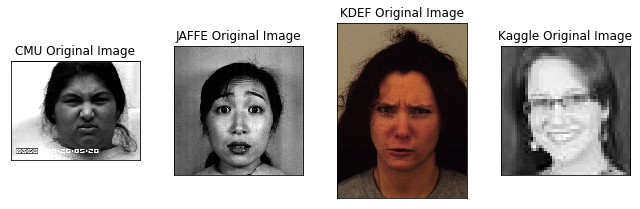

In [6]:
original_images = ['CMU Data/cohn-kanade-images/S005/001/S005_001_00000008.png',
                 'jaffe/JPG Images//KA.FE4.48.jpg',
                 'KDEF/AF02/AF02ANS.JPG',
                 'All Images/Downsampled Images/KAGGLE_00000007.jpg']
image_title = ['CMU Original Image', 'JAFFE Original Image', 
               'KDEF Original Image', 'Kaggle Original Image']
plt.figure(figsize=(9,4))
for i,image_path in enumerate(original_images): # plot each original image
    plt.subplot(1,4,i+1)
    image = imread(image_path)
    imshow(image)
    plt.title(image_title[i])
    plt.xticks([])
    plt.yticks([])
plt.savefig("Project Images/originals.pdf",bbox_inches="tight")
plt.show()

I used the labels that each researcher had included in their dataset upon its compolation. One dataset had the labels included in a folder structure, and two others had the labels included in the file name. This extraction code is in the attached file.

I believe that each of my sources for the dataset were reliable. Three of them were from accredited universities studying facial expressions in their Psychology department, and one dataset was taken from an old Kaggle competition. Because of the size of the Kaggle dataset, 87.5% of my data is from Kaggle, and only 12.5% is from the other 3 sources. My data is well-suited to answer the questions I have posed about whether it is possible for machines to differentiate human facial expressions. I believe this because of the nature of my data - the images are consistent and identical in shape, size, and resolution. The code required to make these edits to the images required the bulk of my data cleaning efforts. The relevant code is in the auxiliary file. Below are examples of the cleaned images.

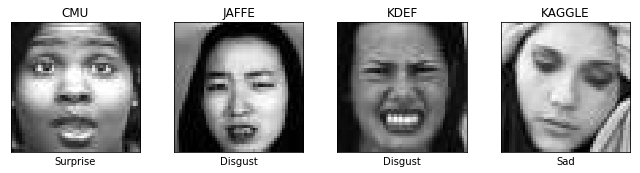

In [7]:
sample_images = []
fileList = list(image_features.index.values)
image_types = ['CMU', 'JAFFE', 'KDEF', 'KAGGLE']
plt.figure(figsize=(9,4))
# plot one final image from each dataset
for i,image_type in enumerate(image_types): 
    image_path = np.random.choice(fileList, 1)[0]
    while image_type not in image_path:
        image_path = np.random.choice(fileList, 1)[0]
    sample_images.append(base_dir + image_path)
    plt.subplot(1,4,i+1)
    # read image
    image = imread(base_dir + image_path)
    image = exposure.rescale_intensity(image)
    imshow(image)
    plt.title(image_type)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(image_features.loc[image_path]['EmotionStr'])
plt.savefig("Project Images/cleaned_examples.pdf",bbox_inches="tight")
plt.show()

For my dataset, potential problems could arise because all of the images are of different resolutions. To combat this, I reshaped and downsampled my images so they are all the same size, shape, resolution, and showing the same area of the face. However, problems could arise from this procedure because some of the faces were not precisely centered in the image, so a few of the faces in the dataset are cropped through part of the face. If this incorporates a larger portion of the dataset than I realize, this could cause later problems with classification.

## Feature Engineering

For my feature engineering, I decided to focus on extrapolating the elements of the picture that might help me to idenfity facial expression later in this project. Namely, I focused on determining aspects of the picture that might prove beneficial to determining the facial expression. In particular, I focused on engineering features of the data that would allow me to later include them into a classification algorithm. By focusing on these aspects of the picture, I think that I will be able to more easily find a converging algorithm, since I will be able to bootstrap whatever algorithm I am applying with relevant data to facial expression. The final dataframe with my engineered features has 8 columns. It is worthwhile to note that many of my features are entire images, rather than categories or numbers.

Initially, I tried to use pre-discovered convolution kernels contained in the cv2 package to identify edges in the image. I think that this feature could significantly help to solve my problem of detecting facial expression because it highlights the drastic transitions in light in the face. Specifically, it hilights the eye, nose, and mouth areas of the face, which convey much of the emotion. Currently, the distinct features of the face may be obfuscated by realistic coloring, even in grayscale. Thus, by emphasizing the more drastic changes from light to dark, I think that the facial expression will be easier to detect. The cv2 kernel contains three distinct edge detection algorithms - the Laplacian, which detects edges of all orientations, the Sobel X which detects vertical edges, and the Sobel Y which detects horizontal edges. The results of edge detection from each of these three images was also saved as a feature of the image in a directory structure mimicking that of the original image. I also constructed a new feature from the Sobel X and Sobel Y edge detections, where I averaged the two images together. The resulting image indicates all edges, but appears to preserve more facial detail than the Laplace edge detection. I also saved this image as a new feature in the dataframe. The filename of each edge image was saved in a dataframe. Some examples of what these pre-trained convolution kernels can be seen below:

In [ ]:
path = sample_images[0]
sample_image = path.split('/')[-1]
img = imread(path)

titles = ['Laplacian', 'Sobel X', 'Sobel Y', 'Average Sobel']
im_types = ['Laplacian', 'SobelX', 'SobelY', 'SobelComb']
plt.figure(figsize=(9,4))
plt.subplot(1,5,1),plt.imshow(img/255.,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
# plot each type of edge detection
for i, im_info in enumerate(zip(titles, im_types)): 
    title, im_type = im_info
    im_path = image_features.loc[sample_image][im_type]
    im = imread('All Images/' + im_path)
    plt.subplot(1,5,i+2),plt.imshow(im/np.max(im),cmap = 'gray')
    plt.title(title), plt.xticks([]), plt.yticks([])
plt.savefig("Project Images/laplacian_examples.pdf",bbox_inches="tight")
plt.show()

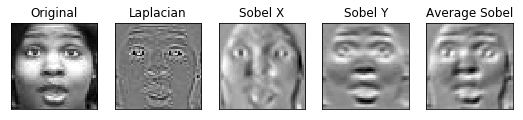

In [15]:
path = sample_images[0]
sample_image = path.split('/')[-1]
img = imread(path)

titles = ['Laplacian', 'Sobel X', 'Sobel Y', 'Average Sobel']
im_types = ['Laplacian', 'SobelX', 'SobelY', 'SobelComb']
plt.figure(figsize=(9,4))
plt.subplot(1,5,1),plt.imshow(img/255.,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
# plot each type of edge detection
for i, im_info in enumerate(zip(titles, im_types)): 
    title, im_type = im_info
    im_path = image_features.loc[sample_image][im_type]
    im = imread('All Images/' + im_path)
    plt.subplot(1,5,i+2),plt.imshow(im/np.max(im),cmap = 'gray')
    plt.title(title), plt.xticks([]), plt.yticks([])
plt.savefig("Project Images/transform_examples.pdf",bbox_inches="tight")
plt.show()

I also extracted additional features from my dataset using the cv2 package to find the strongest corners in an image. This differs from the edge detection because instead of generating an entire image, this function generates a list of (x,y) pairs. The strongest corners are determined using a Harris corner detector. This corner detector relies on the gradient of the 2x2 covariance matrix calculated at each pixel in the image to create a score for the strength of the corner at each pixel using the formula $\texttt{dst} (x,y) =  \mathrm{det} M^{(x,y)} - k  \cdot \left ( \mathrm{tr} M^{(x,y)} \right )^2$. These corner scores are then sorted, and only the strongest 10 were returned. Thus, our resulting feature is a list of 10 (x,y) pairs corresponding to the strongest corners in the image. Examples of these strong corners can be seen below.

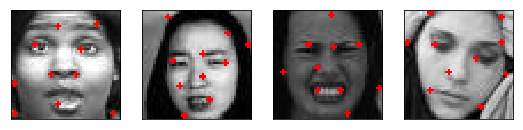

In [9]:
plt.figure(figsize=(9,4))
for i, path in enumerate(sample_images):
    sample_image = path.split('/')[-1]
    img = cv2.imread(path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # generate list of strongest corners in image
    corners = cv2.goodFeaturesToTrack(gray,minDistance=10,
                                      qualityLevel=0.01,
                                      maxCorners=10)
    corners = np.int0(corners)
    
    plt.subplot(1,4,i+1)
    for i in corners:
        x,y = i.ravel()
        # plot strong corners
        cv2.circle(img,(x,y),1,255,-1) 
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.savefig("Project Images/strong_corners_example.pdf",bbox_inches="tight")
plt.show()

It is interesting that the strongest corners in an image correlate with the eyes, nose, and mouth on the face, as well as the edges of the face. I believe that this is a relevant feature because these strong corners appear to be concentrated with the areas of the face that humans rely on to evaluate facial expression.

## Data Visualization

I was most interested in identifying the distribution of my data so that I can properly train models in the next stage of this project. In particular, I want to know whether my feature engineering appears to be relevant and useful, and whether I have a representative sample of each type of facial expression. Using irrelevant features or trying to distinguish facial expressions with very few examples could result in a biased clasifier or I could get an inaccurate idea of how well my classifier is performing because of my sparse examples.

#### Mean Faces for Emotions

I chose to investigate the mean faces of the dataset to determine if each expression has a distinct look in the aggregate. If these faces create meaningful representations of each of the emotions, we could create a simple classifier by comparing relevant features, such as eye, nose, and mouth pixel brightness to the average to distinguish emotions.

In [10]:
def create_mean_face(filenames, start_dir, save_filename='All_Faces'):
    """
    Averages the images for each face in the list of filenames provided.
    filenames: list of paths to face images
    save_as: filename to save resulting image
    """
    mean_image = np.zeros(shape=(48,48), dtype=np.float32)
    for n, file in enumerate(filenames):
        image = imread(start_dir + file)
        delta = image - mean_image
        mean_image += delta/(n+1)
    imsave(fname='All Images/'+save_filename+'.png',
           arr=mean_image/255.)
    return mean_image

In [ ]:
emotions = ['All', 'Neutral', 'Happy', 'Sad',
            'Anger', 'Fear', 'Disgust', 'Surprise']
all_face_filenames = list(image_features['Filename'])
create_mean_face(all_face_filenames, start_dir='All Images/Downsampled Images/')
# display mean face for each emotion
for i, emotion in enumerate(emotions): 
    emotion_df = image_features.loc[image_features['EmotionStr'] == emotion]
    face_filenames = emotion_Df['Filename']
    create_mean_face(face_filenames, start_dir=base_dir,
                     save_filename=f'{emotion}_Face')

plt.figure(figsize=(6,3))
for i, emotion in enumerate(emotions): # display mean face for each emotion
    plt.subplot(2,4,i+1)
    filename = f'All Images/{emotion}_Face.png'
    if emotion == 'All':
        filename = f'All Images/{emotion}_Faces.png'
    im = imread(filename)
    plt.imshow(im)
    plt.title(f'Mean \n{emotion} Face')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.savefig("Project Images/mean_faces.pdf",bbox_inches="tight")
plt.show()

Based on the above plots, we can see that meaningful representations of each group is represented in the aggregate. This means that we might be able to improve classification by removing excess noise from the dataset by mean-centering the data. It also suggests that by extracting features from the image, such as eye, nose, and mouth average pixel brightness values, we could distinguish between facial expressions. For example, if the average pixel intensity around the eyes is fairly light, we might infer that the picture is representing disgust or a neutral facial expression, since the eyes of each other facial expression is very dark. If we then compared average pixel brighness for the area aound the mouth, and found it to be darker than the average neutral brightness, we might conclude that the image was in fact conveying disgust. Similarly, if an image had relatively dark eyes and mouth, the image could be conveying fear or surprise. Thus, the mean images give us relevant insight into the data.

Similarly, the edge detection algorithms provide meaningful insight into the data since they allow us to extract relevant features in a more robust way than comparing average pixel brighness. We can see below the average Laplacian and Sobel Combination edge detection results for each emotion.

#### Laplacian Average Faces

In [ ]:

# create average Laplacian and Sobel Comb face for each emotion
for i, emotion in enumerate(emotions): 
    if emotion == 'All':
        face_filenames = image_features['Laplacian']
        face_filenames = image_features['SobelComb']
    else:
        emotion_df = image_features.loc[image_features['EmotionStr'] == emotion]
        face_filenames = laplacian_df['Laplacian']
        face_filenames = emotion_df['SobelComb']
    create_mean_face(face_filenames, start_dir='All Images/', 
                     save_filename=f'{emotion}_Laplacian_Face')
    create_mean_face(face_filenames, start_dir='All Images/', 
                     save_filename=f'{emotion}_SobelComb_Face')

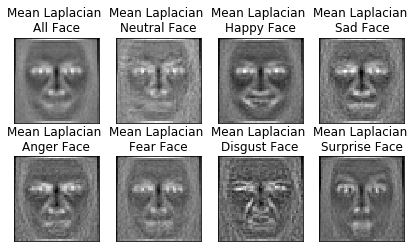

In [6]:
plt.figure(figsize=(7,4))
# display average Laplacian face for each emotion
for i, emotion in enumerate(emotions): 
    plt.subplot(2,4,i+1)
    filename = f'All Images/{emotion}_Laplacian_Face.png'
    im = imread(filename)
    plt.imshow(im)
    plt.title(f'Mean Laplacian \n{emotion} Face')
    plt.xticks([])
    plt.yticks([])
plt.savefig("Project Images/laplacians.pdf",bbox_inches="tight")
plt.show()

Notice that in these filters, we see excellent granularity in the image around the eyes and eyebrows, but the mouth area tends to be rather blurry. This is because the eyes are more consistently in the same location than the jaw. Thus, it is easy to distinguish between very different emotions in these images based on the eyes and eyebrows, but difficult to distinguish between emotions with similar eye positions, such as anger and fear.

#### Sobel Combination Average Faces

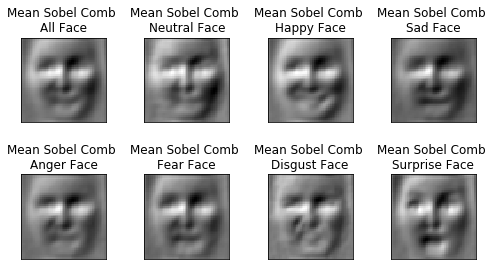

In [7]:
plt.figure(figsize=(7,4))
# display average Sobel Comb face for each emotion
for i, emotion in enumerate(emotions): 
    plt.subplot(2,4,i+1)
    filename = f'All Images/{emotion}_SobelComb_Face.png'
    im = imread(filename)
    plt.imshow(im)
    plt.title(f'Mean Sobel Comb \n{emotion} Face')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.savefig("Project Images/sobel_comb.pdf",bbox_inches="tight")
plt.show()

These results indicate that the Sobel Combination filter is providing meaningful data about the area in the image around the mouth. While we lose most of the information around the eyes, since the eye socket is dark and the cheekbones are light in every image, we maintain most of the information about the mouth and jaw position. Then, it is easy to distinguish between anger, surprise, and happiness, but very difficult to discriminate between anger and fear.

Because each of these filters provides a unique benefit to the overall classification, it would be most beneficial to include elements of each when classifying the image. For example, it would be most beneficial to use the information about the eyes and eyebrow positions from the Laplacian filter, and information about the mouth from the Sobel filter.

Similarly, we can utilize the engineered features about the strong corners in the image to distinguish between different facial expressions. The points representing the strongest corners in the image found from the cv2 package are plotted on a 48x48 grid. Each time a pixel represents a strong corner, its value is incremented by 1. The results and code for this analysis are shown below.

In [8]:
def convert_str_to_array(points):
    """
    Parses string representation of array into a 2-d array of (x,y) values
    """
    points_list = points.split('\n')
    points_list = [p.split() for p in points_list]
    points_list = [l.split('[')[-1] for p in points_list for l in p]
    points_list = [p.split(']')[0] for p in points_list if p is not '']
    
    points_array = np.array(points_list)
    points_array = points_array.reshape((-1, 2))
    return points_array.astype(np.int32)

def convert_points_to_heatmap(points):
    """
    Generate heatmap for strong corners on the face.
    Increments pixel value by 1 each time the pixel
        is identified as a strong corner.
    """
    heatmap = np.zeros((48,48))
    for p in points:
        heatmap[p[1],p[0]] += 1
    return heatmap

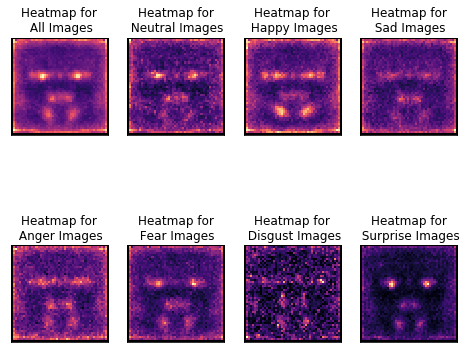

In [12]:
# heatmap on features from edge detection
emotions = ['All', 'Neutral', 'Happy', 'Sad', 
            'Anger', 'Fear', 'Disgust', 'Surprise']
corners = image_features['Corners']
num_all_corners = len(corners)
avg_strong_corners = [0]*len(emotions)

plt.figure(figsize=(8,7))
for i, emotion in enumerate(emotions):
    if emotion == 'All':
        corners = image_features['Corners']
    else:
        emotion_df = image_features.loc[image_features['EmotionStr'] == emotion]
        corners = emotion_df['Corners']
    corners_array = [convert_str_to_array(c) for c in corners]
    corners_array = np.vstack(corners_array)
    corners_array = corners_array.reshape((-1,2))
    # get average number of strong corners in the images
    avg_strong_corners[i] = corners_array.shape[0]/len(corners)
    heatmap = convert_points_to_heatmap(corners_array)
    heatmap /= num_all_corners
    
    plt.subplot(2,4,i+1)
    plt.imshow(heatmap, cmap='magma')
    plt.xticks([]), plt.yticks([])
    plt.title(f'Heatmap for\n {emotion} Images')
plt.savefig("Project Images/heatmaps.pdf",bbox_inches="tight")
plt.show()

From this visualization, we can see that there are distinct differences in where the strong corners of an image lie based on the emotion conveyed. Namely, we can see that images conveying sadness appear to have the least highly concentrated strong corners of any emotion. By contrast, happy images seem to have the most highly concentrated strong corners. Based on this visualization, if we could only see up to the strongest 10 corners in an image, we might be able to distinguish the emotion conveyed. High concentration of corners on the edge of the image appears to correspond to anger or happiness, wheras high very concentration on the center of the eye is consistent with the heatmap for fear or surprise. Similarly, strong corners on the edges of the mouth correlate to happiness, and strong corners across the center of the brow and on the nostrils seem correlated with expressing anger.

## Conclusion

Overall, I found some very interesting results from my data cleaning and visualization. Most notably, I found that the emotion conveyed in an image plays a large role in where the strong corners present in an image lie. This was particularly important because it provided a basis for distinguishing between human emotions in images. I also found that even with imperfect data, human emotions are often distinct enough to create meaningful representations of the emotion in the aggregate. This suggests that it could be worthwhile to mean-center the data, since features to classifying the data could become more obvious.

For the next stages of this project, I will likely remove the disgusted faces from the dataset for the first stages of classification, because there are so few examples, and thus there will likely be an excess of noise for this area of the classifier. Once I have completed a few iterations on my classifier, I may include the disgusted faces again to determine how well this classifier can learn with comparatively few training examples.